# Predicting Heart Disease

This is a binary classification projection––with or without heart disease––with the overall goal of model accuracy. The dataset, [obtained from Kaggle](https://www.kaggle.com/danimal/heartdiseaseensembleclassifier?select=Heart_Disease_Data.csv), consists of 303 observations and [13 features](https://www.kaggle.com/iamkon/ml-models-performance-on-risk-prediction#Complete-attribute-documentation). Of the 303 observation, 160 are without heart disease and the remaining 143 have some degree of heart disease. The study from which the data are drawn distinguishes between not having heart disease (0, in the 'pred_attribute' column) and 4 degrees of having the disease (1, 2, 3, 4). [Experiments with this dataset have concentrated on simply distinguishing between having and not having the disease](https://www.kaggle.com/iamkon/ml-models-performance-on-risk-prediction), and I have done the same here.

The dataset is already fairly clean, which gave me an opportunity to spend more time comparing the performance of a variety of models––a logistic regression model, SVCs, a KNN model, decision trees and Random Forests, and AdaBoost and XGBoost––as well as to try putting together an ensemble of my own.

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
import collections

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from xgboost import XGBClassifier

%matplotlib inline

## Exploratory Data Analysis

In [151]:
df = pd.read_csv('data/Heart_Disease_Data.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slop,ca,thal,pred_attribute
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [152]:
df.shape

(303, 14)

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age               303 non-null int64
sex               303 non-null int64
cp                303 non-null int64
trestbps          303 non-null int64
chol              303 non-null int64
fbs               303 non-null int64
restecg           303 non-null int64
thalach           303 non-null int64
exang             303 non-null int64
oldpeak           303 non-null float64
slop              303 non-null int64
ca                303 non-null object
thal              303 non-null object
pred_attribute    303 non-null int64
dtypes: float64(1), int64(11), object(2)
memory usage: 33.3+ KB


Here, I'm taking a closer look at categorical variables.

In [154]:
df['ca'].value_counts()

0    176
1     65
2     38
3     20
?      4
Name: ca, dtype: int64

In [155]:
df['thal'].value_counts()

3    166
7    117
6     18
?      2
Name: thal, dtype: int64

I change placeholder values to 'None' so I can use .dropna to drop these very few observations from my dataset. That seemed the simpler solution than trying to impute values on a categorical variable.

In [156]:
df['ca'].loc[df['ca']=='?'] = None
df['thal'].loc[df['thal']=='?'] = None

/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [157]:
df = df.dropna(axis=0)
df['ca'] = df['ca'].astype('int')
df['thal'] = df['thal'].astype('int')
X = df.drop('pred_attribute', axis=1)
y = df['pred_attribute']

Let's take a look at the distribution of values for each feature.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b34aba0b8>,
      dtype=object)

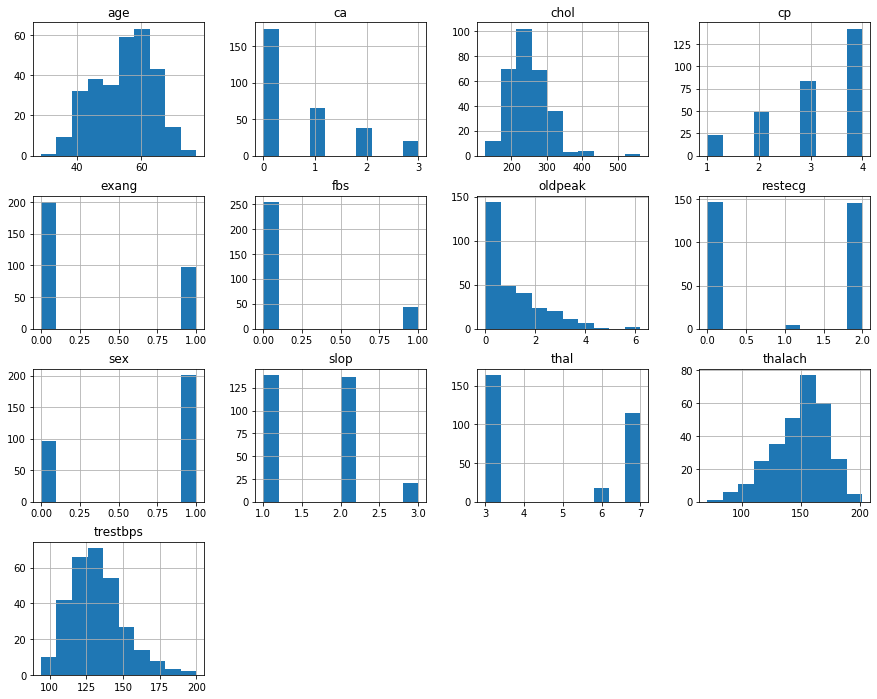

In [158]:
X.hist(figsize=(15, 12))

'ca', 'cp', 'exang', 'fbs', 'restecg', 'sex', 'slop', 'thal' ALL appear to be categorical. My continuous variables have very different ranges––\[0, 6\] for 'oldpeak', but \[100, 200\] for 'trestbps'––so I'll probably standardize them to be on the safe side.

Below, I'm casting all my labels greater than 0 as 1 because, for the sake of this project, 1, 2, 3, 4 are all degrees of heart disease. Simply recasting them all as 1.

In [159]:
y[y>0]=1

/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


And with that, it's time to create train and test sets, as well as to try a first set of models to see how they perform out of the box.

## Very Early Baseline Models

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)

In [161]:
baseline_classifiers = {'LogReg': LogisticRegression(random_state=42),
                        'KNN': KNeighborsClassifier(n_neighbors=3),
                        'SVC': SVC(gamma='auto', random_state=42),
                        'DT': DecisionTreeClassifier(random_state=42),
                        'RF': RandomForestClassifier(random_state=42),
                        'Ada': AdaBoostClassifier(DecisionTreeClassifier(random_state=42), random_state=42), 
                        'XGB': XGBClassifier(random_state=42)}

baseline = {}
for clf in baseline_classifiers:
    name = clf
    clf = baseline_classifiers[clf]
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    baseline[name] = acc
print(pd.Series(baseline).sort_values(ascending=False))

LogReg    0.866667
RF        0.826667
XGB       0.813333
DT        0.773333
Ada       0.720000
KNN       0.586667
SVC       0.546667
dtype: float64


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Not bad at all, with logistic regression and a random forest leading the pack at 83% accuracy on test data. KNN and (radial basis function) SVC don't do much better than random guessing though.

Before I move onto tuning models, I want to try tuning my data first. Who said, "Good models don't come from good models; good models come from good data"?

## Feature Engineering

I start by looking for highly correlated features and using a Random Forest to gauge feature importance.

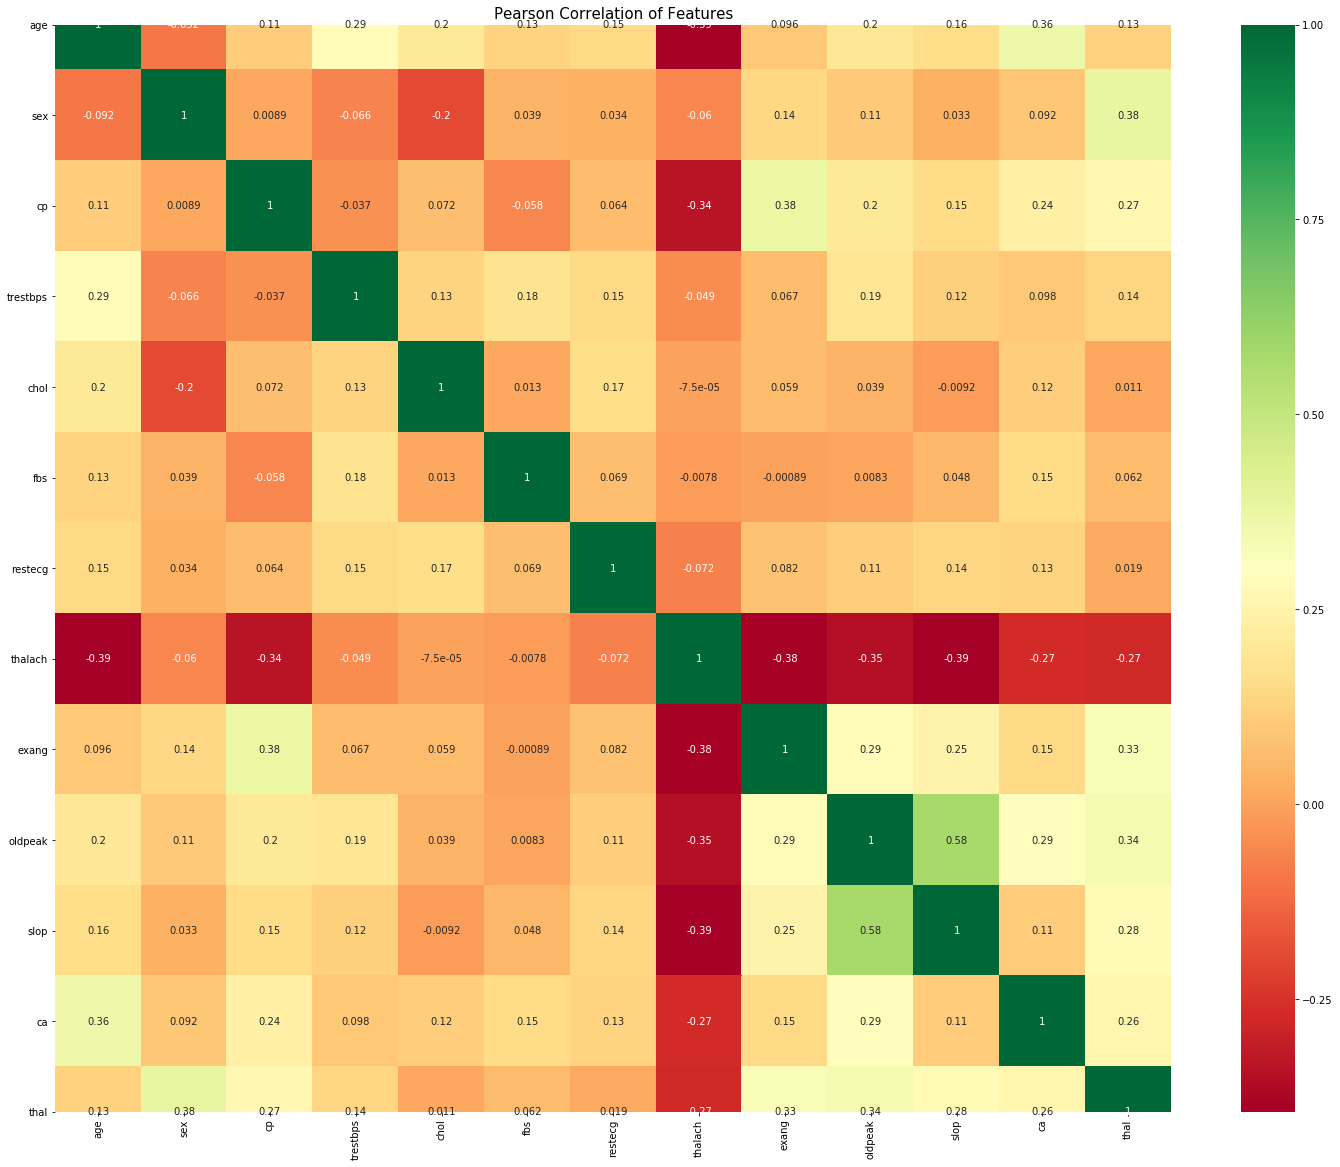

In [162]:
sns.heatmap(X.corr(),annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(25,20)
#plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
plt.show()

In [163]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

thalach     0.128969
cp          0.122558
thal        0.112145
ca          0.106617
oldpeak     0.104328
age         0.091347
chol        0.083361
trestbps    0.080489
exang       0.064376
slop        0.046107
sex         0.027416
restecg     0.024662
fbs         0.007625
dtype: float64

According to this model, 'thalach' appears to be the most import feature for this dataset, but looking at the heatmap above, it's also the most correlated with the most other features. If I had to pick just one feature, I'd choose this one, but for the sake of choosing multiple features, I'm going to exclude it; none of my other features are so highly correlated with each other. I take instead 'cp' through 'trestbps' (cutoff chosen somewhat arbitrarily).

In [198]:
new_colspace = ['oldpeak', 'chol', 'age', 'trestbps', 'ca', 'cp', 'thal']
X_train = X_train[new_colspace]
X_test = X_test[new_colspace]

And I standardize my predictors.

In [199]:
ss = StandardScaler()
X_train = pd.DataFrame(ss.fit_transform(X_train), columns=new_colspace)
X_test = pd.DataFrame(ss.transform(X_test), columns=new_colspace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b31f343c8>,
      dtype=object)

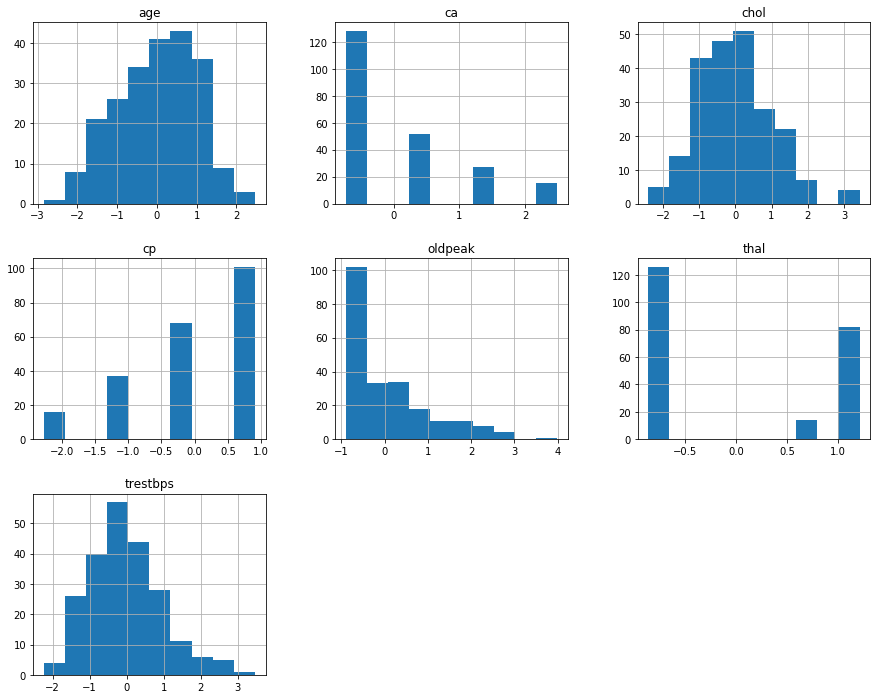

In [166]:
X_train.hist(figsize=(15, 12))

Much better. My features are now all spread, more or less, between \[-2, 2\].

## New Baseline Models for Processed Data

In [167]:
baseline_classifiers = {'LogReg': LogisticRegressionCV(random_state=42),
                        'KNN': KNeighborsClassifier(n_neighbors=3),
                        'SVC': SVC(gamma='auto', random_state=42),
                        'DT': DecisionTreeClassifier(random_state=42),
                        'RF': RandomForestClassifier(random_state=42),
                        'Ada': AdaBoostClassifier(DecisionTreeClassifier(random_state=42), random_state=42), 
                        'XGB': XGBClassifier(random_state=42)}

baseline = {}
for clf in baseline_classifiers:
    name = clf
    clf = baseline_classifiers[clf]
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    baseline[name] = acc
print(pd.Series(baseline).sort_values(ascending=False))

RF        0.853333
LogReg    0.853333
KNN       0.840000
SVC       0.813333
XGB       0.800000
Ada       0.760000
DT        0.746667
dtype: float64


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


**Most models are seeing a lot of improvement––the KNN model's accuracy increased from 59% to 84%; the SVC's accuracy incrased from 55% to 81%––with the exception of dear XGBoost, which saw a 4% decrease. I'll use these models as my baseline for comparing models with finetuned hyperparameters.**

## Tuning Model Hyperparameters

I used [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) in my baseline model as opposed to LogisticRegression, which is probably why it performed so well out of the box, so it's already pretty well tuned. I start with the KNN model.

### KNN

In [168]:
clf_knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': list(range(1, 100)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3],
    
}
gs_knn = GridSearchCV(clf_knn, param_grid, scoring='accuracy', cv=10)
gs_knn.fit(X_train, y_train)
print(f'Train Accuracy: {gs_knn.best_score_}')
test_accuracies = {}
test_accuracies['KNN'] = accuracy_score(y_test, gs_knn.predict(X_test))
print(f'Test Accuracy: {test_accuracies["KNN"]}')
print(gs_knn.best_params_)

Train Accuracy: 0.8288288288288288
Test Accuracy: 0.8266666666666667
{'n_neighbors': 60, 'p': 2, 'weights': 'distance'}


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Support Vector Classifier (Linear)

In [169]:
clf_svcl = SVC(random_state=42, probability=True)
param_grid = {
    'kernel': ['linear'], 
    'C': np.linspace(.1, 1, 10), 
    'gamma': ['scale', 'auto'], 
}
gs_svcl = GridSearchCV(clf_svcl, param_grid, scoring='accuracy', cv=10)
gs_svcl.fit(X_train, y_train)
print(f'Train Accuracy: {gs_svcl.best_score_}')
test_accuracies['Linear SVC'] = accuracy_score(y_test, gs_svcl.predict(X_test))
print(f'Test Accuracy: {test_accuracies["Linear SVC"]}')
print(gs_svcl.best_params_)

Train Accuracy: 0.8063063063063063
Test Accuracy: 0.8533333333333334
{'C': 0.7000000000000001, 'gamma': 'scale', 'kernel': 'linear'}


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Test accuracy is quite a bit higher than train accuracy, which is a good sign the model isn't overfitting.

### Support Vector Classifier (Polynomial)

In [170]:
clf_svcp = SVC(random_state=42, probability=True)
param_grid = {
    'kernel': ['poly'], 
    'degree': list(range(2, 6)), 
    'coef0': np.linspace(.1, 1, 10), 
    'C': np.linspace(.1, 1, 10), 
    'gamma': ['scale', 'auto'], 
}
gs_svcp = GridSearchCV(clf_svcp, param_grid, scoring='accuracy', cv=10)
gs_svcp.fit(X_train, y_train)
print(f'Train Accuracy: {gs_svcp.best_score_}')
test_accuracies['Polynomial SVC'] = accuracy_score(y_test, gs_svcp.predict(X_test))
print(f'Test Accuracy: {test_accuracies["Polynomial SVC"]}')
print(gs_svcp.best_params_)

Train Accuracy: 0.8063063063063063
Test Accuracy: 0.8133333333333334
{'C': 0.30000000000000004, 'coef0': 0.9, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Support Vector Classifier (Sigmoid)

In [171]:
clf_svcs = SVC(random_state=42, probability=True)
param_grid = {
    'kernel': ['sigmoid'],
    'coef0': np.linspace(1, 50, 10), 
    'C': np.linspace(.01, .1, 10), 
    'gamma': ['scale', 'auto'], 
}
gs_svcs = GridSearchCV(clf_svcs, param_grid, scoring='accuracy', cv=10)
gs_svcs.fit(X_train, y_train)
print(f'Train Accuracy: {gs_svcs.best_score_}')
test_accuracies['Sigmoid SVC'] = accuracy_score(y_test, gs_svcs.predict(X_test))
print(f'Test Accuracy: {test_accuracies["Sigmoid SVC"]}')
print(gs_svcs.best_params_)

Train Accuracy: 0.8243243243243243
Test Accuracy: 0.88
{'C': 0.07, 'coef0': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Like the linear SVC, the sigmoid SVC seems to be excelling on test data.

### Support Vector Classifier (Radial Basis Function)

In [172]:
clf_svcrbf = SVC(random_state=42, probability=True)
param_grid = {
    'kernel': ['rbf'],
    'coef0': np.linspace(.001, .01, 10), 
    'C': np.linspace(.01, .1, 10), 
    'gamma': ['scale', 'auto'], 
}
gs_svcrbf = GridSearchCV(clf_svcrbf, param_grid, scoring='accuracy', cv=10)
gs_svcrbf.fit(X_train, y_train)
print(f'Train Accuracy: {gs_svcrbf.best_score_}')
test_accuracies['RBF SVC'] = accuracy_score(y_test, gs_svcrbf.predict(X_test))
print(f'Test Accuracy: {test_accuracies["RBF SVC"]}')
print(gs_svcrbf.best_params_)

Train Accuracy: 0.8108108108108109
Test Accuracy: 0.8533333333333334
{'C': 0.05000000000000001, 'coef0': 0.001, 'gamma': 'scale', 'kernel': 'rbf'}


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Decision Tree

In [173]:
clf_dt = DecisionTreeClassifier(random_state=42)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, 7, 9, 11, 13, 15], 
    'min_samples_split': [10, 20, 30, 40, 50, 60], 
    'min_samples_leaf': [5, 10, 15, 20, 25, 30, 35, 40],
}
gs_dt = GridSearchCV(clf_dt, param_grid, scoring='accuracy', cv=10)
gs_dt.fit(X_train, y_train)
print(f'Train Accuracy: {gs_dt.best_score_}')
test_accuracies['Decision Tree'] = accuracy_score(y_test, gs_dt.predict(X_test))
print(f'Test Accuracy: {test_accuracies["Decision Tree"]}')
print(gs_dt.best_params_)

Train Accuracy: 0.8198198198198198
Test Accuracy: 0.8666666666666667
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 10}


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [174]:
'''
Used this code to produce a .png file with visualization of decision tree.
Commented out now so as not to produce multiple files.
'''

# dot_data = tree.export_graphviz(gs_dt.best_estimator_,
#                                 feature_names=X_train.columns,
#                                 out_file=None,
#                                 filled=True,
#                                 rounded=True)
# graph = pydotplus.graph_from_dot_data(dot_data)

# colors = ('turquoise', 'orange')
# edges = collections.defaultdict(list)

# for edge in graph.get_edge_list():
#     edges[edge.get_source()].append(int(edge.get_destination()))

# for edge in edges:
#     edges[edge].sort()    
#     for i in range(2):
#         dest = graph.get_node(str(edges[edge][i]))[0]
#         dest.set_fillcolor(colors[i])

# graph.write_png('tree.png')

'\nUsed this code to produce a .png file with visualization of decision tree.\nCommented out now so as not to produce multiple files.\n'

### Random Forest

In [175]:
clf_rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 500, 1000], 
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 7, 20], 
    'min_samples_split': [10, 40, 100], 
    'min_samples_leaf': [10, 100],
}
gs_rf = GridSearchCV(clf_rf, param_grid, verbose=1, scoring='accuracy', cv=3)
gs_rf.fit(X_train, y_train)
print(f'Train Accuracy: {gs_rf.best_score_}')
test_accuracies['Random Forest'] = accuracy_score(y_test, gs_rf.predict(X_test))
print(f'Test Accuracy: {test_accuracies["Random Forest"]}')
print(gs_rf.best_params_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 192 candidates, totalling 576 fits
Train Accuracy: 0.8063063063063063
Test Accuracy: 0.8533333333333334
{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}


[Parallel(n_jobs=1)]: Done 576 out of 576 | elapsed:  3.1min finished


### AdaBoost

In [176]:
clf_ab = AdaBoostClassifier(algorithm='SAMME.R', random_state=42)
param_grid = {
    'base_estimator': [DecisionTreeClassifier(max_depth=1), LogisticRegression(solver='lbfgs', multi_class='auto')], 
    'n_estimators': [10, 30, 50, 1000], 
    'learning_rate': [.0001, .001, .01, .1]
}
gs_ab = GridSearchCV(clf_ab, param_grid, scoring='accuracy', cv=5)
gs_ab.fit(X_train, y_train)
print(f'Train Accuracy: {gs_ab.best_score_}')
test_accuracies['AdaBoost'] = accuracy_score(y_test, gs_ab.predict(X_test))
print(f'Test Accuracy: {test_accuracies["AdaBoost"]}')
print(gs_ab.best_params_)

/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train Accuracy: 0.8423423423423423
Test Accuracy: 0.8666666666666667
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), 'learning_rate': 0.001, 'n_estimators': 1000}


### XGBoost

In [177]:
clf_xgb = XGBClassifier(random_state=42, probability=True)
param_grid = {
    'max_depth': [1, 3, 5],
    'learning_rate': [.05, .1, .15], 
    'subsample': [.7, .8, .9],
    'colsample_bytree': np.linspace(.1, 1, 10),
    'min_child_weight': [10, 20, 30], 
    'n_estimators': [10, 100, 500]
}
gs_xgb = GridSearchCV(clf_xgb, param_grid, scoring='accuracy', cv=5)
gs_xgb.fit(X_train, y_train)
print(f'Train Accuracy: {gs_xgb.best_score_}')
test_accuracies['XGBoost'] = accuracy_score(y_test, gs_xgb.predict(X_test))
print(f'Test Accuracy: {test_accuracies["XGBoost"]}')
print(gs_xgb.best_params_)

Train Accuracy: 0.8423423423423423
Test Accuracy: 0.84
{'colsample_bytree': 0.5, 'learning_rate': 0.15, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 10, 'subsample': 0.9}


/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Summary

In [178]:
test_accuracies['lr'] = baseline['LogReg']
pd.Series(test_accuracies).sort_values(ascending=False)

Sigmoid SVC       0.880000
AdaBoost          0.866667
Decision Tree     0.866667
lr                0.853333
Random Forest     0.853333
RBF SVC           0.853333
Linear SVC        0.853333
XGBoost           0.840000
KNN               0.826667
Polynomial SVC    0.813333
dtype: float64

## Creating an Ensemble Classifier

Here I selected the three top performing models: the sigmoid kernel from the SVCs, AdaBoost from the boosters, and the decision tree over the random forest, for a total of **3 individual models**. I combined them into a single voting classifier below.

In [203]:
clf_votehard = VotingClassifier(
    estimators=[('svcs', gs_svcs.best_estimator_),
                ('dt', gs_dt.best_estimator_), 
                ('ab', gs_ab.best_estimator_)],
    voting='hard')
clf_votehard.fit(X_train, y_train)
accuracy_score(y_test, clf_votehard.predict(X_test))

0.8666666666666667

In [204]:
confusion_matrix(y_test, clf_votehard.predict(X_test))

array([[35,  5],
       [ 5, 30]])

This ensemble method does as well as two of the individual models, the decision tree and AdaBoost, but not as well the sigmoid SVC. I tried the same model, but with a soft voting system, giving a little more weight to the sigmoid SVC as it performed best on its own. I also included the KNN model hoping the extra diversity in models might produce a more powerful ensemble.

In [206]:
clf_votesoft = VotingClassifier(
    estimators=[('knn', gs_knn.best_estimator_),
                ('svcs', gs_svcs.best_estimator_), 
                ('dt', gs_dt.best_estimator_), 
                ('ab', gs_ab.best_estimator_)],
    voting='soft', 
    weights=[1, 3, 1, 1])
clf_votesoft.fit(X_train, y_train)
accuracy_score(y_test, clf_votesoft.predict(X_test))

0.8666666666666667

In [181]:
confusion_matrix(y_test, clf_votesoft.predict(X_test))

array([[34,  6],
       [ 4, 31]])

Again, the model performs as well as the decision tree and AdaBoost each do alone, making this a none too impressive model. 

Lastly, and I found this completely on accident, if I use the original data before standardization and dimensionality reduction and include the logistic regression model, I get the best accuracy on test data of all models. I find myself wishing I had an extra test dataset on which to try these 3 different ensemble models.

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)
clf_votesoft = VotingClassifier(
    estimators=[('lr', baseline_classifiers['LogReg']),
                ('knn', gs_knn.best_estimator_), 
                ('svcs', gs_svcs.best_estimator_), 
                ('dt', gs_dt.best_estimator_), 
                ('ab', gs_ab.best_estimator_)],
    voting='soft', 
    weights=[1, 1, 3, 2, 2])
clf_votesoft.fit(X_train, y_train)b
accuracy_score(y_test, clf_votesoft.predict(X_test))

/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/stlanier/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/stlanier/opt/a

0.8933333333333333

In [196]:
confusion_matrix(y_test, clf_votesoft.predict(X_test))

array([[37,  3],
       [ 5, 30]])

In [182]:
'''
Here I tried a lot of different weight combos in a soft vote classifier 
with 4 of the best performing models, but wasn't able to beat the 87%-89% accuracy
above. Already the algorithm is time consuming, and it is inelegant, so I have
commented it out. Possibly future work.
'''

# w = [0, 1, 2, 3]
# combos = []
# scores = []
# for a in w:
#     for b in w:
#         for c in w:
#             for d in w:
#                 if a==0 and b==0 and c==0 and d==0: 
#                     continue
#                 else:
#                     clf_votesoft = VotingClassifier(
#                         estimators=[('lr', baseline_classifiers['LogReg']), 
#                                     ('svcs', gs_svcs.best_estimator_),
#                                     ('dt', gs_dt.best_estimator_), 
#                                     ('ab', gs_ab.best_estimator_)],
#                         voting='soft', 
#                         weights=[a, b, c, d])
#                     clf_votesoft.fit(X_train, y_train)
#                     combos.append([a, b, c, d])
#                     scores.append(accuracy_score(y_test, clf_votesoft.predict(X_test)))
# df = pd.DataFrame([combos, scores]).T
# df.columns = ['combos', 'accuracy']
# df.sort_values(by='combos', ascending=True).head(15)

"\nHere I tried a lot of different weight combos in a soft vote classifier \nwith 4 of the best performing models, but wasn't able to beat the 87% accuracy\nabove. Already the algorithm is time consuming, and it is inelegant, so I have\ncommented it out. Possibly future work.\n"

## Conclusion

1. There was little preprocessing necessary for this project as the [dataset](https://www.kaggle.com/danimal/heartdiseaseensembleclassifier) was already quite clean. I used a **heatmap of Pearson correlation coefficients** to identify correlated features (which I dropped) and used **feature importance** from a Random Forest to select the 7 most important features of the original 13. Lastly, I **standardized** all features. 


2. After tuning, accuracy on test data improved for all models except logistic regression, which lost 2% accuracy:

| Model | Initial Test Accuracy | Final Test Accuracy |
|-|-|-|
| Ensemble Classifier (Soft, Unprocessed) | -- | **89%** |
| Sigmoid SVC | 55% | **88%** |
| AdaBoost | 72% | **87%** |
| Decision Tree | 77% | **87%** |
| Ensemble Classifier (Soft) | -- | **87%** |
| Ensemble Classifier (Hard) | -- | **87%** |
| Logistic Regression | 87% | **85%** |
| Random Forest | 83% | **85%** |
| XGBoost | 81% | **84%** |
| KNN | 59% | **82%** |


3. On the preprocessed, feature-selected data, hard- and soft-vote ensemble classifiers both achieved 87% accuracy on test data. The hard-vote ensemble consisted of a sigmoid SVC, a decision tree, and an AdaBoost classifier; the soft-vote classifier additionally included a KNN classifier.


4. **The model with the highest accuracy on test data (89%) was a soft-vote ensemble classifier using a sigmoid SVC, a decision tree, an AdaBoost classifier, a KNN classifier, and a logistic regression classifier. It was only able to achieve this accuracy on data *that had not undergone dimensionality reduction or standardization* (but had been cleaned of missing values).**